In [25]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/drive/MyDrive/Data Analysis/DIG_Stock.csv')
df1=df.reset_index()['Price']

In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [ ]:
def augment_features(dataframe):
    fracocp = (dataframe['Price']-dataframe['Open'])/dataframe['Open']
    frachp = (dataframe['High']-dataframe['Open'])/dataframe['Open']
    fraclp = (dataframe['Open']-dataframe['Low'])/dataframe['Open']
    new_dataframe = pd.DataFrame({'delOpenPrice': fracocp,
                                 'delHighOpen': frachp,
                                 'delLowOpen': fraclp})
    new_dataframe.set_index(dataframe.index)

    return new_dataframe

In [ ]:
def extract_features(dataframe):
    return np.column_stack((dataframe['delOpenPrice'], dataframe['delHighOpen'], dataframe['delLowOpen']))

In [ ]:
features = extract_features(augment_features(train_data))

In [ ]:
!pip install hmmlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 6.1 MB/s eta 0:00:00


In [ ]:
from hmmlearn.hmm import GaussianHMM
model = GaussianHMM(n_components=10)

In [ ]:
feature_train_data = augment_features(train_data)
features_train = extract_features(feature_train_data)
model.fit(features_train)

GaussianHMM(n_components=10)

In [ ]:
import itertools

test_augmented = augment_features(test_data)
fracocp = test_augmented['delOpenPrice']
frachp = test_augmented['delHighOpen']
fraclp = test_augmented['delLowOpen']

sample_space_fracocp = np.linspace(fracocp.min(), fracocp.max(), 50)
sample_space_fraclp = np.linspace(fraclp.min(), frachp.max(), 10)
sample_space_frachp = np.linspace(frachp.min(), frachp.max(), 10)

possible_outcomes = np.array(list(itertools.product(sample_space_fracocp, sample_space_frachp, sample_space_fraclp)))

In [ ]:
num_latent_days = 50
num_days_to_predict = 30

In [ ]:
from tqdm import tqdm

predicted_close_prices = []
for i in tqdm(range(num_days_to_predict)):
    # Calculate start and end indices
    previous_data_start_index = max(0, i - num_latent_days)
    previous_data_end_index = max(0, i)
    # Acquire test data features for these days
    previous_data = extract_features(augment_features(test_data.iloc[previous_data_start_index:previous_data_end_index]))

    outcome_scores = []
    for outcome in possible_outcomes:
        # Append each outcome one by one with replacement to see which sequence generates the highest score
        total_data = np.row_stack((previous_data, outcome))
        outcome_scores.append(model.score(total_data))

    # Take the most probable outcome as the one with the highest score
    most_probable_outcome = possible_outcomes[np.argmax(outcome_scores)]
    predicted_close_prices.append(test_data.iloc[i]['Open'] * (1 + most_probable_outcome[0]))

100%|██████████| 30/30 [00:55<00:00,  1.85s/it]


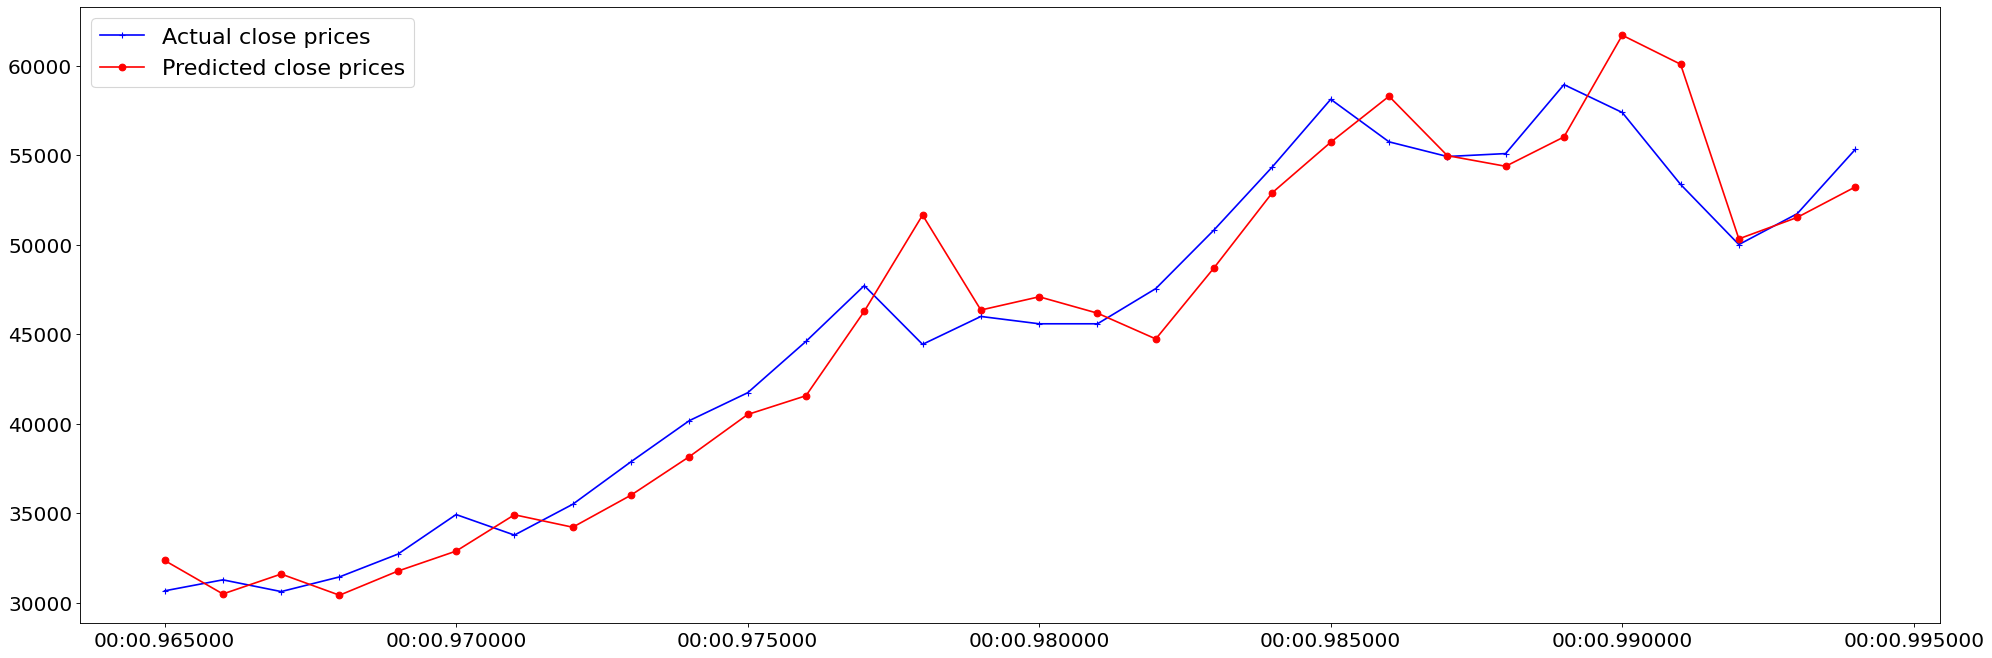

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30,10), dpi=80)
plt.rcParams.update({'font.size': 18})

x_axis = np.array(test_data.index[0:num_days_to_predict], dtype='datetime64[ms]')
plt.plot(x_axis, test_data.iloc[0:num_days_to_predict]['Price'], 'b+-', label="Actual close prices")
plt.plot(x_axis, predicted_close_prices, 'ro-', label="Predicted close prices")
plt.legend(prop={'size': 20})
plt.show()

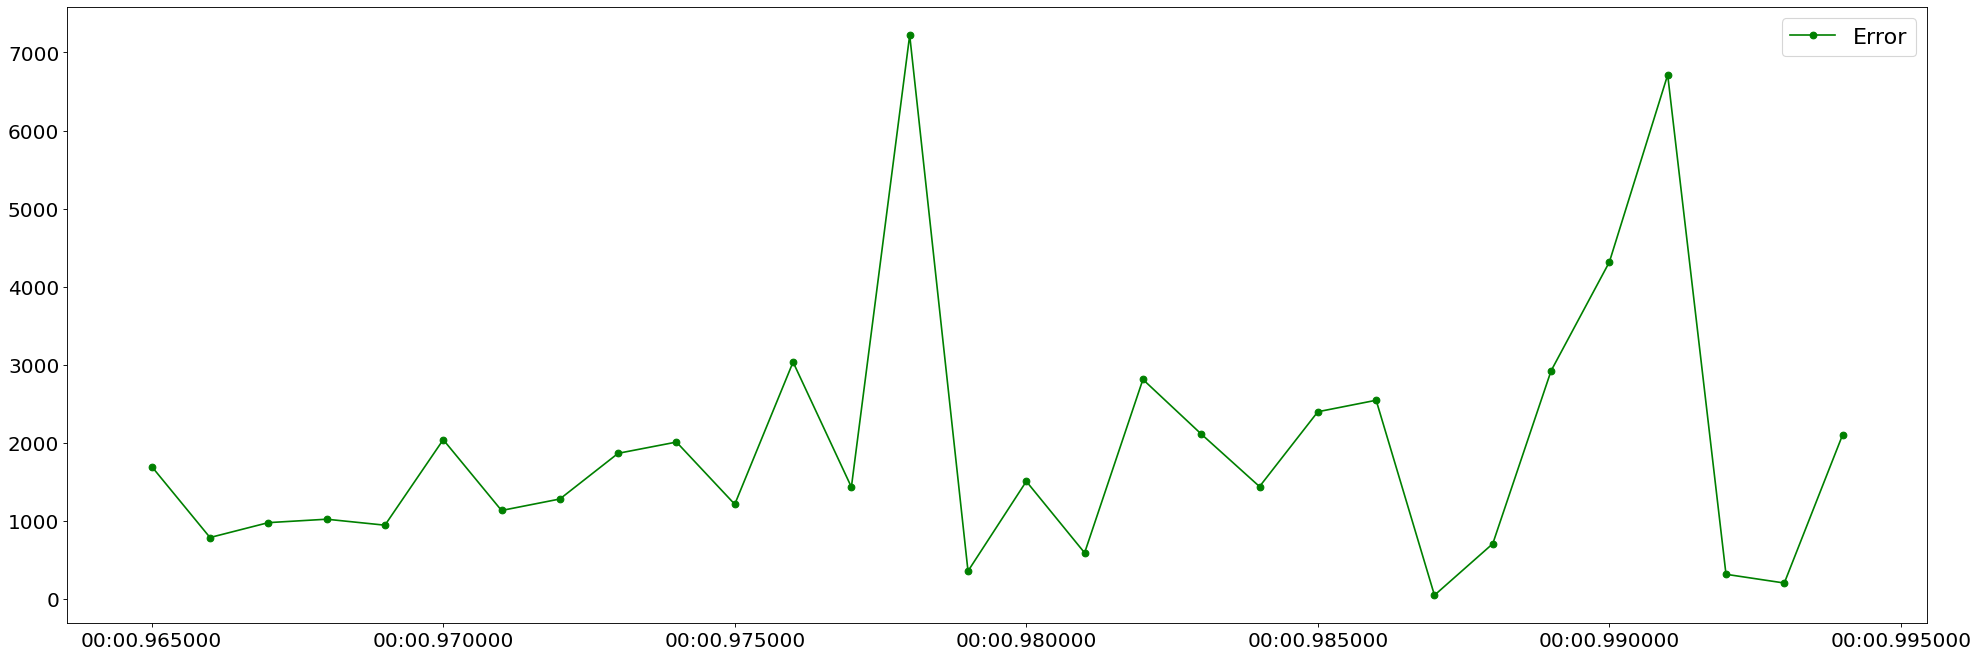

In [ ]:
ae = abs(test_data.iloc[0:num_days_to_predict]['Price'] - predicted_close_prices)

plt.figure(figsize=(30,10), dpi=80)

plt.plot(x_axis, ae, 'go-', label="Error")
plt.legend(prop={'size': 20})
plt.show()

In [26]:
!pip install hmmlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Validation MAPE: 324.48036282056296
Testing MAPE: 236.62040575318284
Validation MAE: 73661.91315789471
Testing MAE: 62172.386858974365
Validation RMSE: 76613.01897769794
Testing RMSE: 63365.42690192377


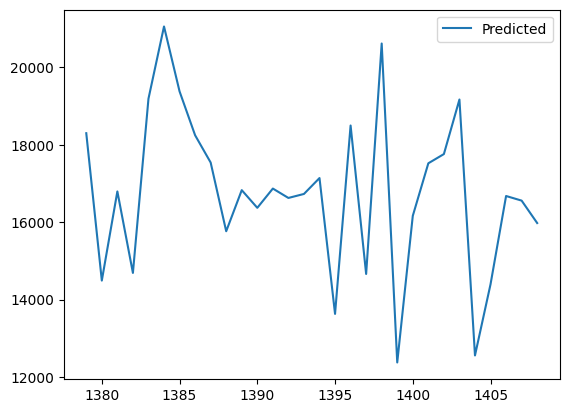

In [33]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from hmmlearn.hmm import GaussianHMM


# 1. Đọc file csv và gắn index với giá Close

df = pd.read_csv('/content/drive/MyDrive/Data Analysis/SSI_Stock.csv')

df1 = df.reset_index()['Price']



# 2. Scaler data

scaler = MinMaxScaler(feature_range=(0, 1))

df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))


# 3. Chia train test

train_size = int(0.7 * len(df1))

test_size = int(0.2 * len(df1))

val_size = len(df1) - train_size - test_size



train_data = df1[:train_size]

test_data = df1[train_size:train_size + test_size]

val_data = df1[train_size + test_size:]



# 4. Hàm Create Dataset

import numpy


# convert an array of values into a dataset matrix

def create_dataset(dataset, time_step=1):

    dataX, dataY = [], []

    for i in range(len(dataset) - time_step - 1):

        a = dataset[i:(i + time_step), 0]  ###i=0, X=0,1,2,3-----99   Y=100

        dataX.append(a)

        dataY.append(dataset[i + time_step, 0])

    return numpy.array(dataX), numpy.array(dataY)


# 5. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100

X_train, y_train = create_dataset(train_data, time_step)

X_val, yval = create_dataset(val_data, time_step)

X_test, ytest = create_dataset(test_data, time_step)


# 6. Reshape input to be [samples, time steps, features] which is required for LSTM

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)


# 7. Define HMM Model

model = GaussianHMM(n_components=10)

# 8. Fit model with training data

model.fit(train_data)


# 9. Generate predictions for test and validation data

train_predict = model.predict(X_train.squeeze())

y_pred = model.predict(X_test.squeeze())

y_pred_val = model.predict(X_val.squeeze())



# 10. Inverse transform the predictions

train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1))

y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

y_pred_val = scaler.inverse_transform(y_pred_val.reshape(-1, 1))



# 11. Calculate evaluation metrics

def calculate_mape(y_true, y_pred):

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def calculate_mae(y_true, y_pred):

    return np.mean(np.abs(y_true - y_pred))


def calculate_rmse(y_true, y_pred):

    return np.sqrt(np.mean((y_true - y_pred)**2))


# Inverse transform the original data

yval = scaler.inverse_transform(yval.reshape(-1, 1))

ytest = scaler.inverse_transform(ytest.reshape(-1, 1))

valid_mape = calculate_mape(yval, y_pred_val)

test_mape = calculate_mape(ytest, y_pred)

valid_mae = calculate_mae(yval, y_pred_val)

test_mae = calculate_mae(ytest, y_pred)

valid_rmse = calculate_rmse(yval, y_pred_val)

test_rmse = calculate_rmse(ytest, y_pred)


print('Validation MAPE:', valid_mape)

print('Testing MAPE:', test_mape)

print('Validation MAE:', valid_mae)

print('Testing MAE:', test_mae)

print('Validation RMSE:', valid_rmse)

print('Testing RMSE:', test_rmse)
# 12. Đoạn mã còn lại để dự đoán và vẽ biểu đồ

# ...
# 13. Initialize the Gaussian HMM model
# 15. Generate predictions for the next 30 days using the trained HMM model

predicted_data, _ = model.sample(n_samples=30)

# 16. Rescale the predicted data back to the original scale

predicted_data = scaler.inverse_transform(predicted_data.reshape(-1, 1))

# 17. Create an index for the predicted data

predicted_data_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 30, step=1)

# 18. Plot the predicted data

plt.plot(predicted_data_index, predicted_data)

plt.legend(['Predicted'])

plt.show()

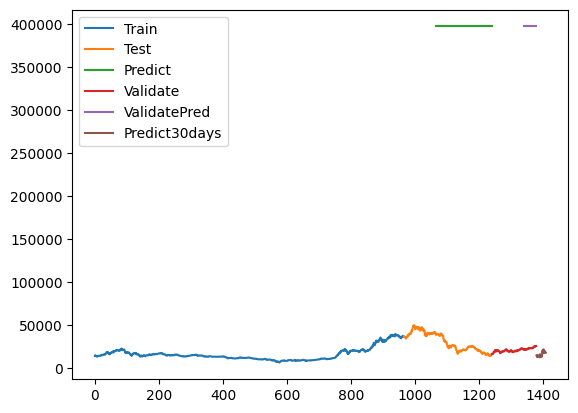

In [31]:
# 12. Đoạn mã còn lại để dự đoán và vẽ biểu đồ

# Vẽ biểu đồ Train, Test, Validate
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,(y_pred_val))

# 13. Initialize the Gaussian HMM model


# 18. Plot the predicted data

plt.plot(predicted_data_index, predicted_data)


# 19. Add legend and show the plot

plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])

plt.show()